# Looking at distribution of Stellar Parameters

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from astropy.table import Table
from scipy.optimize import curve_fit

%matplotlib inline

In [2]:
star_tab = Table.read('data/sampling_fit_results.txt',format='ascii')
star_tab.show_in_notebook()

idx,Teff,logg,vmic,mh,cm,nm,am
0,4526.726562,2.581831,0.214553760315,0.188104,-0.174295,0.415533,0.049715
1,4522.675781,2.567737,0.215765870173,0.180001,-0.175437,0.441165,0.06257
2,4518.398926,2.559878,0.21644029234,0.178605,-0.175369,0.408703,0.045687
3,4526.098145,2.580253,0.214689639511,0.182012,-0.175251,0.443764,0.063365
4,4522.675781,2.567931,0.215749208759,0.180001,-0.175437,0.441165,0.06257
5,4515.53418,2.5585,0.216558437932,0.17661,-0.184529,0.435969,0.051597
6,4526.987793,2.576315,0.21502854943,0.183816,-0.175936,0.437139,0.063111
7,4521.87207,2.563569,0.216123678626,0.180275,-0.18108,0.445948,0.062681
8,4526.098145,2.580603,0.214659505209,0.182012,-0.175251,0.443764,0.063365
9,4524.235352,2.547018,0.217541622587,0.176256,-0.184383,0.443617,0.060674


In [3]:
def dr12teff(raw_teff):
    '''This function applies the DR12 calibration to Effective Temperature'''
    #Add in limits for applicable teffs
    if raw_teff < 3000:
        raw_teff = 3000
    if raw_teff > 6000:
        raw_teff = 6000
    calib_teff = raw_teff - 0.0034*(raw_teff-4500)+87.9
    return calib_teff
def dr12logg(raw_logg):
    '''This function applies the DR12 calibration to RGB Log g (do not use on RC stars).'''
    calib_logg = raw_logg + 0.14*raw_logg-0.588
    return calib_logg
def dr12M_H(raw_M_H,teff):
    '''This function applies the DR12 calibration [M/H] log g <= 3.8'''
    
    #I don't know whether Teff is raw or calibrated or not
    if teff < 3800:
        teff = 3800
    if teff > 5250:
        teff = 5250
    
    #Cluster Offset
    calib_M_H = raw_M_H +0.056*(teff -4500)/1000
    #Now add outside calibration
    extern_M_H = calib_M_H + 0.0260 + 0.255*calib_M_H + 0.062*calib_M_H**2
    return extern_M_H
def dr12alpha(raw_alpha,teff):
    '''This function applies the DR12 calibration [M/H] log g <= 3.8'''
    
    #I don't know whether Teff is calibrated or not
    if teff < 3800:
        teff = 3800
    if teff > 5250:
        teff = 5250   

    calib_alpha = raw_alpha +0.028*(teff -4500)/1000
    
    return calib_alpha

In [4]:
def gauss(x_data, amp, x0, sigma):
    return amp * np.exp(-(x_data - x0)**2 / (2 * sigma**2))

def lngauss_prob(data,mean,sigma):
    return np.log(1/(sigma*np.sqrt(2*np.pi)))-0.5*((data-mean)/sigma)**2

def get_posterior(values,x_values,sigma=1.0):
    lnprob = 0
    for value in values:
        lnprob = lnprob + lngauss_prob(x_values,value,sigma)
        
    #Return to prob space
    prob = lnprob
    return prob

In [5]:
pp = PdfPages('Distributions.pdf')

In [6]:
corr_teff = list()
for rawteff in star_tab['Teff']:
    corr_teff.append(dr12teff(rawteff))

star_tab['Teff_corr'] = corr_teff

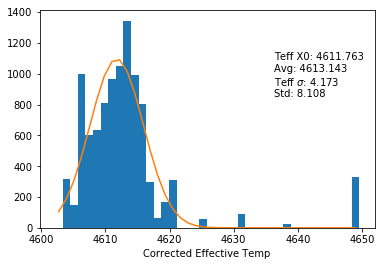

In [7]:
mybins = 40
(y,edges,patches) = plt.hist(star_tab['Teff_corr'],bins=mybins)

mean = np.mean(star_tab['Teff_corr'])
sigma = np.std(star_tab['Teff_corr'])
x = edges[0:-1] + (edges[1:] - edges[0:-1])/2.0

popt,pcov = curve_fit(gauss, x, y, p0=[max(y), mean, sigma])

plt.text(.7,.72,"Teff X0: {:.3f}\nAvg: {:.3f}".format(popt[1],mean),transform=plt.gca().transAxes)
plt.text(.7,.60,"Teff $\sigma$: {:.3f}\nStd: {:.3f}".format(popt[2],sigma),transform=plt.gca().transAxes)

plt.plot(x,gauss(x,popt[0],popt[1],popt[2]))
plt.xlabel('Corrected Effective Temp')
pp.savefig()
plt.show()

In [8]:
corr_logg = list()
for rawlogg in star_tab['logg']:
    corr_logg.append(dr12logg(rawlogg))

star_tab['logg_corr'] = corr_logg

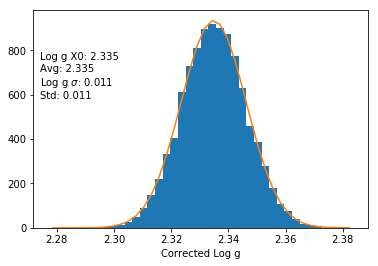

In [9]:
mybins = 40
(y,edges,patches) = plt.hist(star_tab['logg_corr'],bins=mybins)

mean = np.mean(star_tab['logg_corr'])
sigma = np.std(star_tab['logg_corr'])
x = edges[0:-1] + (edges[1:] - edges[0:-1])/2.0

popt,pcov = curve_fit(gauss, x, y, p0=[max(y), mean, sigma])

plt.text(.02,.72,"Log g X0: {:.3f}\nAvg: {:.3f}".format(popt[1],mean),transform=plt.gca().transAxes)
plt.text(.02,.60,"Log g $\sigma$: {:.3f}\nStd: {:.3f}".format(popt[2],sigma),transform=plt.gca().transAxes)

plt.plot(x,gauss(x,popt[0],popt[1],popt[2]))
plt.xlabel('Corrected Log g')
pp.savefig()
plt.show()

In [10]:
corr_mh = list()
for i in np.arange(len(star_tab['mh'])):
    corr_mh.append(dr12M_H(star_tab['mh'][i],star_tab['Teff_corr'][i]))

star_tab['mh_corr'] = corr_mh

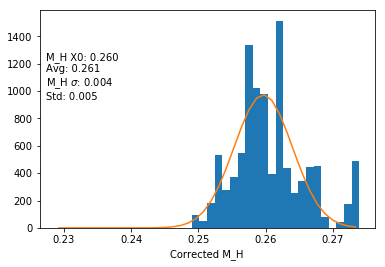

In [11]:
mybins = 40
(y,edges,patches) = plt.hist(star_tab['mh_corr'],bins=mybins)

mean = np.mean(star_tab['mh_corr'])
sigma = np.std(star_tab['mh_corr'])
x = edges[0:-1] + (edges[1:] - edges[0:-1])/2.0

popt,pcov = curve_fit(gauss, x, y, p0=[max(y), mean, sigma])

plt.text(.02,.72,"M_H X0: {:.3f}\nAvg: {:.3f}".format(popt[1],mean),transform=plt.gca().transAxes)
plt.text(.02,.60,"M_H $\sigma$: {:.3f}\nStd: {:.3f}".format(popt[2],sigma),transform=plt.gca().transAxes)

plt.plot(x,gauss(x,popt[0],popt[1],popt[2]))
plt.xlabel('Corrected M_H')
pp.savefig()
plt.show()

In [12]:
corr_am = list()
for i in np.arange(len(star_tab['am'])):
    corr_am.append(dr12alpha(star_tab['am'][i],star_tab['Teff_corr'][i]))

star_tab['am_corr'] = corr_am

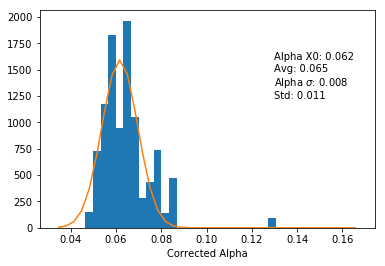

In [13]:
mybins = 40
(y,edges,patches) = plt.hist(star_tab['am_corr'],bins=mybins)

mean = np.mean(star_tab['am_corr'])
sigma = np.std(star_tab['am_corr'])
x = edges[0:-1] + (edges[1:] - edges[0:-1])/2.0

popt,pcov = curve_fit(gauss, x, y, p0=[max(y), mean, sigma])

plt.text(.7,.72,"Alpha X0: {:.3f}\nAvg: {:.3f}".format(popt[1],mean),transform=plt.gca().transAxes)
plt.text(.7,.60,"Alpha $\sigma$: {:.3f}\nStd: {:.3f}".format(popt[2],sigma),transform=plt.gca().transAxes)

plt.plot(x,gauss(x,popt[0],popt[1],popt[2]))
plt.xlabel('Corrected Alpha')
pp.savefig()
plt.show()

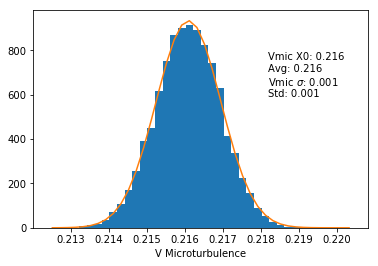

In [14]:
mybins = 40
(y,edges,patches) = plt.hist(star_tab['vmic'],bins=mybins)

mean = np.mean(star_tab['vmic'])
sigma = np.std(star_tab['vmic'])
x = edges[0:-1] + (edges[1:] - edges[0:-1])/2.0

popt,pcov = curve_fit(gauss, x, y, p0=[max(y), mean, sigma])

plt.text(.7,.72,"Vmic X0: {:.3f}\nAvg: {:.3f}".format(popt[1],mean),transform=plt.gca().transAxes)
plt.text(.7,.60,"Vmic $\sigma$: {:.3f}\nStd: {:.3f}".format(popt[2],sigma),transform=plt.gca().transAxes)

plt.plot(x,gauss(x,popt[0],popt[1],popt[2]))
plt.xlabel('V Microturbulence')
pp.savefig()
plt.show()

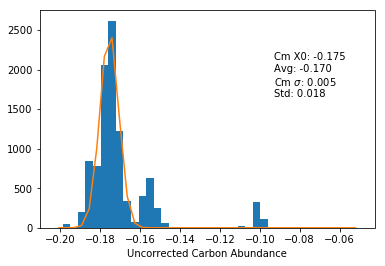

In [15]:
mybins = 40
(y,edges,patches) = plt.hist(star_tab['cm'],bins=mybins)

mean = np.mean(star_tab['cm'])
sigma = np.std(star_tab['cm'])
x = edges[0:-1] + (edges[1:] - edges[0:-1])/2.0

popt,pcov = curve_fit(gauss, x, y, p0=[max(y), mean, sigma])

plt.text(.7,.72,"Cm X0: {:.3f}\nAvg: {:.3f}".format(popt[1],mean),transform=plt.gca().transAxes)
plt.text(.7,.60,"Cm $\sigma$: {:.3f}\nStd: {:.3f}".format(popt[2],sigma),transform=plt.gca().transAxes)

plt.plot(x,gauss(x,popt[0],popt[1],popt[2]))
plt.xlabel('Uncorrected Carbon Abundance')
pp.savefig()
plt.show()

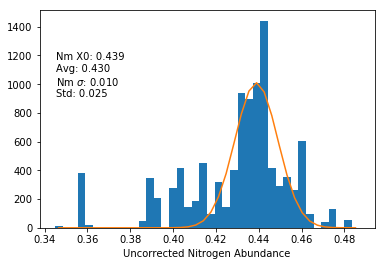

In [16]:
mybins = 40
(y,edges,patches) = plt.hist(star_tab['nm'],bins=mybins)

mean = np.mean(star_tab['nm'])
sigma = np.std(star_tab['nm'])
x = edges[0:-1] + (edges[1:] - edges[0:-1])/2.0

popt,pcov = curve_fit(gauss, x, y, p0=[max(y), mean, sigma])

plt.text(.05,.72,"Nm X0: {:.3f}\nAvg: {:.3f}".format(popt[1],mean),transform=plt.gca().transAxes)
plt.text(.05,.60,"Nm $\sigma$: {:.3f}\nStd: {:.3f}".format(popt[2],sigma),transform=plt.gca().transAxes)

plt.plot(x,gauss(x,popt[0],popt[1],popt[2]))
plt.xlabel('Uncorrected Nitrogen Abundance')
pp.savefig()
plt.show()

In [17]:
pp.close()